### Topic Significance Ranking
- Based on: [Topic Significance Ranking of LDA Generative Models (Alsumait et al.)](https://mimno.infosci.cornell.edu/info6150/readings/ECML09_AlSumaitetal.pdf).
- Data aquisition from [this website](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#3importnewsgroupstextdata) verbatum, with prints removed.


In [1]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize


def TopicSignificanceRanking(count_vector, components, documents):
    '''
    This takes the topics from an LDA model (sklearn) and assigns TSR scores to it.
    
        count_vector: the count vector of the words used in the sklearn model.
    
        components:   the topics generated by the LDA model.
        
        RETURNS Psi and S for each topic (where TSR = Psi x S)
        
    Darin LaSota, 5/30/2018
    '''
    # Turn components into word topic dist
    components = components/components.sum(axis=1)[:, np.newaxis]

    # Derived Quantities
    topics = components.shape[0]  # number of topics
    measures = 3
    measure = ['KL','COR','COS']
    
    # Distributions...
    # W-Uniform is a junk topic in which all the terms of the dictionary are equally probable
    W_Uniform = np.ones(components.shape)/components.shape[1]
    
    # the vacuous semantic distribution (W_Vacuous), is deﬁned to be the empirical distribution of the sample set
    # p(w|W_Vacuous) = Sum Over all Topics, k of p(w|k)p(k)
    W_Vacuous = np.zeros(components.shape)
    p_k = np.sum(documents, axis=0)/np.sum(documents)
    temp = np.zeros(components[0,:].shape)
    for k in range(topics): 
        temp = temp + components[k,:] * p_k[k]  # (2)   
    for k in range(topics):
        W_Vacuous[k,:] = temp

    # the background topic (D-BGround) is found equally probable in all the documents.
    D_BGround = np.ones(documents.shape)/documents.shape[0]
    
    # Construct U, V, and B for each topic k
    U = np.zeros((topics, measures))
    V = np.zeros((topics, measures))
    B = np.zeros((topics, measures))
   
    for k in range(topics):
        # KL = 0
        U[k, 0] = entropy(components[k,:], W_Uniform[k,:])
        V[k, 0] = entropy(components[k,:],  W_Vacuous[k,:])
        # Averaging distance of each document's word to D-BGround
        B[k, 0] = np.mean(entropy(np.array(documents[:,k]), D_BGround[:,k]))

        # COR
        U[k, 1] = np.correlate(components[k,:], W_Uniform[k,:])
        V[k, 1] = np.correlate(components[k,:],  W_Vacuous[k,:])
        # Averaging distance of each document's word to D-BGround
        B[k, 1] = np.mean(np.correlate(documents[:,k], D_BGround[:,k], mode='valid'))

        # COS
        U[k, 2] = cosine(components[k,:].reshape(-1,1), W_Uniform[k,:].reshape(-1,1))
        V[k, 2] = cosine(components[k,:].reshape(-1,1),  W_Vacuous[k,:].reshape(-1,1))
        # Averaging distance of each document's word to D-BGround
        B[k, 2] = np.mean(cosine(documents[:,k].reshape(-1,1),D_BGround[:,k].reshape(-1,1)))
   
    # 4.1 Standardization Proceedure
    # (10) and (11)
    U1 = np.zeros((topics, measures))
    V1 = np.zeros((topics, measures))
    B1 = np.zeros((topics, measures))
    U2 = np.zeros((topics, measures))
    V2 = np.zeros((topics, measures))
    B2 = np.zeros((topics, measures))
    for k in range(topics):
        for m in range(measures):
            # (10)
            U1[k,m] = U[k,m] * (1 - U[k,m]/np.sum(U[:,m], axis=0))
            V1[k,m] = V[k,m] * (1 - V[k,m]/np.sum(V[:,m], axis=0))
            B1[k,m] = B[k,m] * (1 - B[k,m]/np.sum(B[:,m], axis=0))
            # (11)
            U2[k,m] = (U[k,m] - np.min(U[:,m]))/(np.max(U[:,m]) - np.min(U[:,m]))
            V2[k,m] = (V[k,m] - np.min(V[:,m]))/(np.max(V[:,m]) - np.min(V[:,m]))
            B2[k,m] = (B[k,m] - np.min(B[:,m]))/(np.max(B[:,m]) - np.min(B[:,m]))
    
    # correction term to deal with all the same answer
    # only happens when C - Cmin = 0 since Cmax - Cmin = 0
    U1 = np.nan_to_num(U1)
    V1 = np.nan_to_num(V1)
    B1 = np.nan_to_num(B1)
    U2 = np.nan_to_num(U2)
    V2 = np.nan_to_num(V2)
    B2 = np.nan_to_num(B2)
    
    # 4.2 Intra-Criterion Weighted Linear Combination
    S1_U = (U1[:,0] + U1[:,1] + U1[:,2])/3  # (12)
    S1_V = (V1[:,0] + V1[:,1] + V1[:,2])/3  # (12)
    S1_B = (B1[:,0] + B1[:,1] + B1[:,2])/3  # (12)
    S2_U = (U2[:,0] + U2[:,1] + U2[:,2])/3  # (12)
    S2_V = (V2[:,0] + V2[:,1] + V2[:,2])/3  # (12)
    S2_B = (B2[:,0] + B2[:,1] + B2[:,2])/3  # (12)
    
    # 4.3 Inter-Criterion Weighted Combination
 
    # The ﬁrst WC technique is based on Equation (10) and uses the standardized score of the background criterion 
    #    as a weight for the uniformity and vacuousness.
    psi_U = 1 - S1_U/np.sum(S1_U)
    psi_V = 1 - S1_V/np.sum(S1_V)
    S = S1_B*( psi_U * S1_U + psi_V * S1_V)   # (13)
    
    # These weights are assumed to sum to 1 so that the total score remains bounded between zero and one.
    Psi = (1/3) * S2_U + (1/3) * S2_V + (1/3) * S2_B  # (14)
    
    # 4.4 The Final Topic Significance Score
    return Psi, S


In [2]:
# Data import on its own line
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import re, nltk, gensim, spacy
from nltk.stem import WordNetLemmatizer
import pandas as pd


df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')


# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
count_vector = data_vectorized
print(count_vector.shape)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(11314, 9751)


In [3]:
from sklearn.decomposition import LatentDirichletAllocation


model = LatentDirichletAllocation(n_components=9, max_iter=10, verbose=1)
documents = model.fit_transform(count_vector)
components = model.components_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [4]:
Psi, S = TopicSignificanceRanking(count_vector, components, documents)
print(Psi)
print(S)
TSR = Psi*S
print(TSR)

[0.71842588 0.39013392 0.64066241 0.41668375 0.4643769  0.53278644
 0.39886312 0.26139801 0.46346536]
[0.84318365 0.68941784 0.9552546  0.56333702 0.54813697 0.82340912
 0.56780468 0.34724748 0.47726654]
[0.60576496 0.26896528 0.61199572 0.23473338 0.25454215 0.43870121
 0.22647635 0.0907698  0.22119651]


In [5]:
for i in list(TSR.argsort()[-5:][::-1]):
    print()
    print('TOPIC {}'.format(i))
    print(' [TSR',TSR[i],'Psi',Psi[i],'S',S[i],']')
    for j in list(components[i,:].argsort()[-10:][::-1]):
        print('   ',vectorizer.get_feature_names()[j], '(',components[i,j],')')



TOPIC 2
 [TSR 0.6119957168323914 Psi 0.6406624109731758 S 0.955254602658459 ]
    gun ( 1694.4676052991392 )
    armenian ( 1404.6876511570026 )
    say ( 932.1407311656516 )
    people ( 839.2583849052262 )
    turkish ( 740.2076972899267 )
    kill ( 685.5257786876077 )
    weapon ( 580.2489944317596 )
    war ( 493.80344015404114 )
    firearm ( 460.7903893797215 )
    attack ( 411.0671892594087 )

TOPIC 0
 [TSR 0.6057649562775536 Psi 0.7184258780635665 S 0.8431836530030385 ]
    max ( 4414.616662251082 )
    space ( 2039.772495560494 )
    nasa ( 709.3761160270097 )
    use ( 568.3328072553398 )
    program ( 551.5732030970933 )
    launch ( 527.0369894495444 )
    output ( 522.793765293493 )
    center ( 476.0115758065814 )
    entry ( 469.4220598140029 )
    build ( 460.4222725559482 )

TOPIC 5
 [TSR 0.4387012136870176 Psi 0.5327864405568166 S 0.8234091190994458 ]
    game ( 1041.3799478082888 )
    new ( 757.9330742577487 )
    play ( 732.095346100684 )
    sale ( 630.779366237

In [6]:
for i in list(TSR.argsort()[:5][::-1]):
    print()
    print('TOPIC {}'.format(i))
    print(' [TSR',TSR[i],'Psi',Psi[i],'S',S[i],']')
    for j in list(components[i,:].argsort()[-10:][::-1]):
        print('   ',vectorizer.get_feature_names()[j], '(',components[i,j],')')



TOPIC 4
 [TSR 0.25454214600546066 Psi 0.4643769012652478 S 0.5481369665716179 ]
    line ( 1963.9468229041033 )
    organization ( 1937.3897881784387 )
    subject ( 1888.6935048624446 )
    write ( 1770.2162307445456 )
    year ( 1660.8677303980164 )
    good ( 1595.5322889526772 )
    article ( 1500.577667712691 )
    post ( 1412.5572851772133 )
    think ( 1314.7732246171945 )
    host ( 1117.2807918511492 )

TOPIC 3
 [TSR 0.23473338319903633 Psi 0.4166837539746078 S 0.5633370174862654 ]
    write ( 2013.0124733181685 )
    article ( 1543.777360256799 )
    subject ( 1536.0812264051806 )
    line ( 1533.156070012887 )
    organization ( 1522.3886963623645 )
    post ( 1154.1253503680086 )
    right ( 1152.4542807715636 )
    people ( 1057.6542550583354 )
    state ( 924.65893952576 )
    just ( 853.273880797872 )

TOPIC 6
 [TSR 0.22647634614913423 Psi 0.39886312064100155 S 0.5678046789213567 ]
    say ( 2966.896444732413 )
    god ( 2649.5401423739377 )
    people ( 2556.8109550853

### Validity Testing
Comparison of method here to method [here](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/), noting that Perplexity and Log-Likliehood seem to rise/fall with n_components, while TSR has some sort of maximum in the middle.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

def GraphTSR(dct):
    xs = list(dct.keys())
    xs.sort()
    x = []
    y = {}
    yn  = {}
    ym = {}
    yt = {}

    y_labels = ['Log-Likliehood', 'Perplexity', 'Psi', 'S', 'Mean TSR']
    y[0] = []
    y[1] = [] 
    y[2] = []
    y[3] = []
    y[4] = []
    yn[0] = []
    yn[1] = [] 
    yn[2] = []
    yn[3] = []
    yn[4] = []
    ym[0] = []
    ym[1] = [] 
    ym[2] = []
    ym[3] = []
    ym[4] = []
    yt[0] = []
    ym[1] = [] 
    ym[2] = []
    ym[3] = []
    ym[4] = []
    for i in xs:
        if len(dct[i]['log']) >=1:
            x.append(i)
            y[0].append(np.mean(dct[i]['log']))
            y[1].append(np.mean(dct[i]['perplexity']))
            y[2].append(np.mean(dct[i]['Psi']))
            y[3].append(np.mean(dct[i]['S']))
            y[4].append(np.mean(dct[i]['TSR']))

            yn[0].append(np.mean(dct[i]['log']) - (np.std(dct[i]['log'])/(len(dct[i]['log'])**0.5)))
            yn[1].append(np.mean(dct[i]['perplexity']) - (np.std(dct[i]['perplexity'])/(len(dct[i]['perplexity'])**0.5)))
            yn[2].append(np.mean(dct[i]['Psi']) - (np.std(dct[i]['Psi'])/(len(dct[i]['Psi'])**0.5)))
            yn[3].append(np.mean(dct[i]['S']) - (np.std(dct[i]['S'])/(len(dct[i]['S'])**0.5)))
            yn[4].append(np.mean(dct[i]['TSR']) - (np.std(dct[i]['TSR'])/(len(dct[i]['TSR'])**0.5)))

            ym[0].append(np.mean(dct[i]['log']) + (np.std(dct[i]['log'])/(len(dct[i]['log'])**0.5)))
            ym[1].append(np.mean(dct[i]['perplexity']) + (np.std(dct[i]['perplexity'])/(len(dct[i]['perplexity'])**0.5)))
            ym[2].append(np.mean(dct[i]['Psi']) + (np.std(dct[i]['Psi'])/(len(dct[i]['Psi'])**0.5)))
            ym[3].append(np.mean(dct[i]['S']) + (np.std(dct[i]['S'])/(len(dct[i]['S'])**0.5)))
            ym[4].append(np.mean(dct[i]['TSR']) + (np.std(dct[i]['TSR'])/(len(dct[i]['TSR'])**0.5)))

    with plt.xkcd():
    # if True:
        fig, axes = plt.subplots(5,1,sharex=True,figsize=(8,12))
        for i, ax in enumerate(axes.flatten()):
            best=[]
            if i == 1:
                ax.axhline(np.min(y[i]), xmin=0, xmax=1, c='r', alpha=0.75, 
                           label='min {} = {:.2f}'.format(y_labels[i],np.min(y[i])))
                ax.axvline(x[y[i].index(np.min(y[i]))],0,0, c='k', ls='', 
                           label='Best # Topics: {}'.format(x[y[i].index(np.min(y[i]))]))
                ax.legend(loc='upper center', bbox_to_anchor=(0,.2,1,0.8), 
                      fancybox=True, shadow=False, ncol=2, fontsize='small')
                ax.axhline(yn[i][y[i].index(np.min(y[i]))],0,1,linestyle=':',c='r',alpha=0.75)
                ax.axhline(ym[i][y[i].index(np.min(y[i]))],0,1,linestyle=':',c='r',alpha=0.75)
            else:
                ax.axhline(np.max(y[i]), xmin=0, xmax=1, c='r', alpha=0.75, 
                           label='max {} = {:.4f}'.format(y_labels[i],np.max(y[i])))
                ax.axvline(x[y[i].index(np.max(y[i]))],0,0, c='k', ls='', 
                           label='Best # Topics: {}'.format(x[y[i].index(np.max(y[i]))]))
                ax.legend(loc='lower center', bbox_to_anchor=(0,0,1,0.2), 
                      fancybox=True, shadow=False, ncol=2, fontsize='small')

                best_x = x[y[i].index(np.max(y[i]))]
                best.append( best_x )
                ax.axhline(yn[i][y[i].index(np.max(y[i]))],0,1,linestyle=':',c='r',alpha=0.75)
                ax.axhline(ym[i][y[i].index(np.max(y[i]))],0,1,linestyle=':',c='r',alpha=0.75)
                for a in ym[i]:
                    if a > yn[i][y[i].index(np.max(y[i]))]:
                        best.append(x[ym[i].index(a)])
            ax.fill_between(x, yn[i], ym[i], color='b', alpha=0.15)
            ax.plot(x,y[i], color='b', ls='solid')
            ax.set_ylabel(y_labels[i])
            if i == 4:
                ax.set_xlabel('n_components')

            ax.set_xlim(np.min(x), np.max(x))
            # ax.tick_params(axis=u'both', which=u'both',length=2)
            ax.set_xticks(x)
    plt.show()
    best = list(set(best))
    best.sort()
    print(best)
    return best

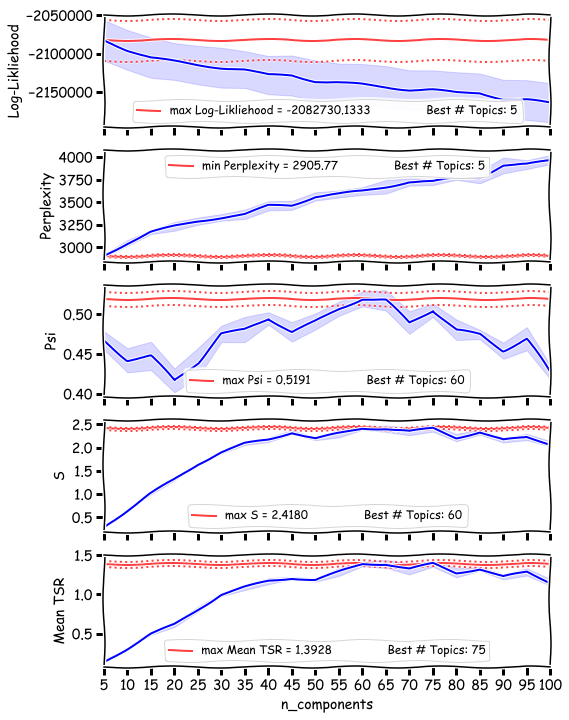

[60, 65, 70, 75]
100.0% Finished


In [8]:
from IPython.display import clear_output
import pickle
from sklearn.model_selection import KFold
import warnings
X = count_vector
warnings.filterwarnings("ignore")
fold = KFold(5)
j = 0

start = 5
step = 5
end = 100
j = -1
for x, y in fold.split(X):
    j += 1
    for n in range(int(end/step)):
        try:
            dct = pickle.load(open('gridct','rb'))
        except:
            dct = {}
        print(dct.keys())
          # SET IT HERE
        n_components =  start + n*step     
        print('Now Running:',n_components)
        try:
            len(dct[n_components])
        except:
            print('-New Data Point-')
            dct[n_components] = {}
            dct[n_components]['Psi'] = []
            dct[n_components]['S'] = []
            dct[n_components]['TSR'] = []
            dct[n_components]['log'] = []
            dct[n_components]['perplexity'] = []
        print(dct.keys())
        max_iter = 4
        model = LatentDirichletAllocation(n_components=n_components, 
                                          max_iter=max_iter, 
                                          n_jobs=-1,
                                          verbose=1,
                                          learning_method='online')
        model.fit(X[x])
        print('model run')
        Y = X[y]
        components = model.components_
        documents = model.transform(Y)
        Psi, S = TopicSignificanceRanking(Y, components, documents)
        dct[n_components]['Psi'].append(np.mean(Psi))
        dct[n_components]['S'].append(np.mean(S))
        dct[n_components]['TSR'].append(np.mean(Psi*S))
        dct[n_components]['log'].append(model.score(Y))
        print("Log Likelyhood {}".format(model.score(Y)))
        dct[n_components]['perplexity'].append(model.perplexity(Y))
        print("Perplexity {}".format(model.perplexity(Y)))
        print('Mean TSR {}'.format(np.mean(Psi*S)))
        pickle.dump(dct, open('gridct','wb'))
        clear_output(wait=True)
        if len(dct.keys()) > 1:
            best = GraphTSR(dct)
        print('{:.1f}% Finished'.format(100*(j*(end/step) + n + 1)/(int(end/step)*5)))


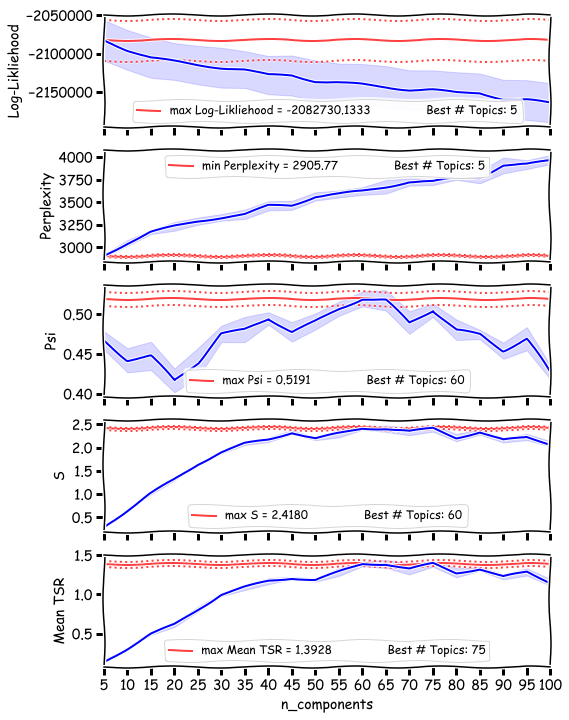

[60, 65, 70, 75]


[60, 65, 70, 75]

In [9]:
 GraphTSR(dct)

In [10]:
dct[100]

{'Psi': [0.4105530877313147,
  0.40653530790019876,
  0.4420118727841237,
  0.41892632992957224,
  0.4572031631681485],
 'S': [2.023090452199506,
  2.0734924625912474,
  2.222013740017578,
  1.8770963360137052,
  2.2142416005687657],
 'TSR': [1.1219609115002256,
  1.0840852086352117,
  1.2500475383327585,
  1.035865088179633,
  1.2810215537863356],
 'log': [-2052540.2038895816,
  -2201289.396885598,
  -2199991.7059412682,
  -2197880.2922052443,
  -2168623.760452017],
 'perplexity': [4048.137574979377,
  4019.0390926805753,
  3759.547524829969,
  3947.823377860444,
  4079.6924722153667]}